## Hybrid_Sim

### Load packages

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import matplotlib.patches as mpatches
import itertools
import os
import pandas as pd
import seaborn as sns

# Set random seeds for NumPy and Python's `random` module.
# Ensures that the simulation results are reproducible each time the code is run with the same seed.
# If reproducibility is not required, these lines can be commented out.
#np.random.seed(32)
#random.seed(32)

### Global Simulation Parameters

In [2]:
# Global Simulation Parameters
# These parameters define the structure and scale of the simulated generations and the chromosomes and loci details.
# They are set globally and are used across various functions and classes in the simulation.

target_f_generation = 10 # Set your desired maximum F-generation here

# chromosome_length: The total number of genetic loci (marker positions) present on a single haploid chromatid.
chromosome_length = 100

# NUM_CHROMOSOMES_P0_F1: The number of diploid chromosome pairs individuals in the P0 and F1 generations.
# For simplicity, P0 and F1 individuals are modelled with a single chromosome pair.
NUM_CHROMOSOMES_P0_F1 = 10

# NUM_CHROMOSOMES_F2_ONWARDS: The number of diploid chromosome pairs for individuals from the F2 generation onwards.
NUM_CHROMOSOMES_F2_ONWARDS = 10

# Population Sizes for Different Generations
# These global constants define the target number of individuals to be simulated for each generation.

NUM_F1_INDIVIDUALS = 2   # Number of individuals in the F1 generation.
NUM_F2_INDIVIDUALS = 2    # Number of individuals in the F2 generation.
NUM_F3_INDIVIDUALS = 2    # Number of individuals in the F3 generation.
NUM_F4_INDIVIDUALS = 2    # Number of individuals in the F4 generation.

# Number of individuals for Backcross generations.
# BC1_A: Backcross of F1 to P0_A (MM parent)
NUM_BC1_A_INDIVIDUALS = 2
# BC1_B: Backcross of F1 to P0_B (YY parent)
NUM_BC1_B_INDIVIDUALS = 2
# BC2_A: Backcross of F2 to P0_A (MM parent)
NUM_BC2_A_INDIVIDUALS = 2
# BC2_B: Backcross of F2 to P0_B (YY parent)
NUM_BC2_B_INDIVIDUALS = 2

# Define allele types and their corresponding colours for visualisation.
MAGENTA = 'M' # Represents the allele from parental line A (MM).
YELLOW = 'Y'  # Represents the allele from parental line B (YY).

# Global colour map: associates allele symbols with specific colours for plotting.
col_map = {MAGENTA: 'magenta', YELLOW: 'yellow'}

# Global list to store all genetic data records (locus-level genotypes).
# Each dictionary in this list will represent the genotype at a single locus for a given individual.
genetic_data_records = []

# Global list to store chromatid-level recombination data (block lengths, junctions).
# This list stores raw data for each chromatid, which will then be aggregated for DataFrames.
chromatid_recombination_records = []

# Global list to store all Individual objects created during the simulation.
# This allows easy access to individual-level metrics like Hybrid Index and Heterozygosity.
all_individuals_created = []

# Global counter for assigning unique identification numbers to each individual created in the simulation.
# Starts at 1 to ensure individual IDs are 1-indexed
individual_id_counter = 1

### Class Definitions

In [3]:
# Class Definitions (Chromosome, DiploidChromosomePair, Individual)
# This cell defines the biological components that form the basis of the genetic simulation:
# a single DNA strand (Chromosome), a pair of homologous chromosomes (DiploidChromosomePair),
# and an entire organism (Individual). The 'Individual' class is extended with methods
# to calculate key genetic metrics such as Hybrid Index and Heterozygosity.

class Chromosome:
    """
    Represents a single haploid chromatid (a single strand of DNA).
    It is a linear sequence of alleles at defined loci.
    In a diploid organism, two chromatids form a chromosome pair.
    """
    def __init__(self, alleles):
        # 'alleles' is a list of characters (e.g., 'M', 'Y'), where each character
        # corresponds to the allele present at a specific locus on this chromatid.
        self.alleles = alleles

    def __repr__(self):
        # Provides a string representation of a Chromosome object.
        # It displays a snippet of the alleles to give an idea of its content without printing the entire sequence.
        snippet = ''.join(self.alleles[:10]) if self.alleles else ''
        return f"Chr({snippet}...)"

class DiploidChromosomePair:
    """
    Represents a pair of chromosomes within a diploid organism.
    One chromatid in the pair is typically inherited from one parent (e.g., paternal origin),
    and the other from the other parent (e.g., maternal origin).
    """
    def __init__(self, chromatid1, chromatid2):
        # 'chromatid1' and 'chromatid2' are instances of the Chromosome class.
        # These represent the two chromatids that constitute this diploid pair.
        self.chromatid1 = chromatid1
        self.chromatid2 = chromatid2

    def __repr__(self):
        # Provides a string representation for a DiploidChromosomePair, showing both constituent chromatids.
        return f"Pair(\n  {self.chromatid1}\n  {self.chromatid2}\n)"

# --- Your Individual Class ---
class Individual:
    """
    Represents a single organism in the simulation. An individual is defined by its
    unique ID, total number of chromosome pairs, and the length of those chromosomes.
    This class includes methods to calculate the Hybrid Index and Heterozygosity
    across the entire genome of the individual.
    """
    def __init__(self, num_chromosomes, num_loci_per_chromosome):
        global individual_id_counter # Access the global counter to assign unique IDs.
        self.id = individual_id_counter # Assign a unique integer ID to this individual.
        individual_id_counter += 1 # Increment the counter for the next individual to be created.

        # 'num_chromosomes': The total count of diploid chromosome pairs in an individual.
        self.num_chromosomes = num_chromosomes
        # 'num_loci_per_chromosome': The number of loci found on each chromatid.
        self.num_loci_per_chromosome = num_loci_per_chromosome # Stored for this individual (though globally fixed here)
        # 'diploid_chromosome_pairs': A list that will hold all the DiploidChromosomePair objects
        #                            that make up this individual's entire hypothetical "genome".
        self.diploid_chromosome_pairs = []

    def __repr__(self):
        # A string representation for an Individual, indicating its ID and the number of chromosome pairs.
        return f"Individual (ID: {self.id}) with {len(self.diploid_chromosome_pairs)} diploid chromosome pairs."

    def get_all_numeric_genotypes(self):
        """
        Gathers all genotype data for the individual across its entire "genome" (all chromosome pairs, all loci).
        It converts the allele pairs (e.g., 'M', 'Y') into a numeric representation for calculation:
        - YY (homozygous Yellow) = 0 (zero 'M' alleles)
        - MY (heterozygous)      = 1 (one 'M' allele)
        - MM (homozygous Magenta)= 2 (two 'M' alleles)

        Returns:
            list: A single, flattened list of integers (0, 1, or 2) representing the genotype at each locus
                  across *all* diploid chromosome pairs of this individual. This is the raw data used for metrics.
        """
        all_numeric_genotypes = []
        # Iterate through each diploid chromosome pair that belongs to this individual.
        for diploid_pair in self.diploid_chromosome_pairs:
            # Get the allele sequences from both chromatids in the current pair.
            alleles_chromatid1 = diploid_pair.chromatid1.alleles
            alleles_chromatid2 = diploid_pair.chromatid2.alleles

            # Iterate through each locus (position) along the length of these chromatids.
            for i in range(self.num_loci_per_chromosome):
                allele_a = alleles_chromatid1[i]
                allele_b = alleles_chromatid2[i]
                # Sort the alleles to ensure consistent ordering (e.g., 'MY' instead of 'YM') for ease of simulation purposes.
                # before assigning a numeric genotype.
                pair = sorted([allele_a, allele_b])

                # Assign numeric genotype based on the sorted allele pair composition.
                if pair == [MAGENTA, MAGENTA]: # Homozygous for Magenta alleles.
                    all_numeric_genotypes.append(2)
                elif pair == [YELLOW, YELLOW]: # Homozygous for Yellow alleles.
                    all_numeric_genotypes.append(0)
                else: # Must be heterozygous (one Magenta, one Yellow allele).
                    all_numeric_genotypes.append(1)
        return all_numeric_genotypes

    def calculate_hybrid_index(self):
        """
        Calculates the aggregate Hybrid Index (HI) for this individual across its entire "genome".
        The HI quantifies the proportion of alleles originating from one parental lineage (specifically Magenta 'M')
        out of all alleles across all loci. It ranges from 0 (all Yellow alleles) to 1 (all Magenta alleles).

        Returns:
            float: The calculated Hybrid Index for the individual, aggregated across all chromosomes.
        """
        # First, retrieve all numeric genotypes for all diploid chromosome pairs in an individual.
        all_numeric_genotypes = self.get_all_numeric_genotypes()

        # Calculate the total number of alleles across all chromosomes.
        # Since each locus has two alleles (one from each chromatid in a diploid pair),
        # the total possible alleles is twice the number of loci.
        total_possible_alleles = len(all_numeric_genotypes) * 2

        # Debugging step: stop division by zero in the rare case of an individual having no loci (e.g., an empty Individual object).
        if total_possible_alleles == 0:
            return 0.0

        # The sum of numeric genotypes (0 for YY, 1 for MY, 2 for MM) directly corresponds
        # to the total count of 'M' (Magenta) alleles present across all chromosomes an individual holds.
        sum_of_m_alleles = sum(all_numeric_genotypes)

        # The Hybrid Index is the proportion of Magenta alleles out of the total possible alleles.
        hybrid_index = sum_of_m_alleles / total_possible_alleles
        return hybrid_index

    def calculate_heterozygosity(self):
        """
        Calculates the aggregate Heterozygosity (He) for this individual across all its chromosomes.
        Heterozygosity represents the proportion of heterozygous loci (MY genotypes)
        out of all loci in the individual's genome. It ranges from 0 (all loci homozygous)
        to 1 (all loci heterozygous).

        Returns:
            float: The calculated Heterozygosity for the individual, aggregated across all chromosomes.
        """
        # Retrieve all numeric genotypes for the individual's full genome.
        all_numeric_genotypes = self.get_all_numeric_genotypes()

        # Count how many of these loci are heterozygous (where the numeric genotype is 1).
        num_heterozygous_loci = all_numeric_genotypes.count(1)

        # The total number of loci across the entire genome is the total count
        # of numeric genotypes that were collected.
        total_num_loci_across_all_chroms = len(all_numeric_genotypes)

        # Prevent division by zero if the individual has no loci.
        if total_num_loci_across_all_chroms == 0:
            return 0.0

        # Heterozygosity is the proportion of heterozygous loci out of all loci.
        heterozygosity = num_heterozygous_loci / total_num_loci_across_all_chroms
        return heterozygosity

    # Method to get recombination block data for all chromatids in the individual
    def get_chromatid_block_data(self):
        """
        Analyses each chromatid within the individual's diploid chromosome pairs
        to determine block lengths and count recombination junctions.

        A 'block' is defined as a contiguous stretch of loci with the same allele (M or Y).
        A 'junction' is defined as a change in allele type (e.g., M -> Y or Y -> M)
        along a single chromatid.

        Returns:
            list: A list of dictionaries, where each dictionary contains data
                  for one chromatid:
                  {
                      'individual_id': int,
                      'diploid_chr_id': int (1-indexed ID of the diploid pair),
                      'chromatid_in_pair': str ('A' or 'B', indicating which chromatid in the pair),
                      'total_junctions': int,
                      'block_lengths': list of int (lengths of consecutive blocks of the same allele),
                      'block_alleles': list of str (allele type of each block, e.g., 'M', 'Y')
                  }
        """
        all_chromatid_data = []
        chromatid_labels = ['A', 'B'] # Define labels for chromatids in a pair

        for chr_idx, diploid_pair in enumerate(self.diploid_chromosome_pairs):
            # Create a list of the two chromatids in the current pair
            # This allows us to loop through them and avoid code duplication
            chromatids_in_pair = [diploid_pair.chromatid1, diploid_pair.chromatid2]

            # Process each chromatid within the pair
            for i, chromatid in enumerate(chromatids_in_pair):
                chromatid_alleles = chromatid.alleles
                # Call the helper method to get analysis results for the current chromatid
                junctions, lengths, alleles = self._analyse_single_chromatid(chromatid_alleles)

                # Append the structured data for the current chromatid
                all_chromatid_data.append({
                    'individual_id': self.id,
                    'diploid_chr_id': chr_idx + 1,          # 1-indexed chromosome ID
                    'chromatid_in_pair': chromatid_labels[i], # Use 'A' or 'B' based on index
                    'total_junctions': junctions,
                    'block_lengths': lengths,
                    'block_alleles': alleles
                })
        return all_chromatid_data

    # Helper method to analyse a single chromatid
    def _analyse_single_chromatid(self, alleles):
        """
        Helper method to analyse a single chromatid's allele sequence for blocks and junctions.
        Uses itertools.groupby for efficient block identification.

        Args:
            alleles (list): A list of allele characters (e.g., 'M', 'Y') for a single chromatid.

        Returns:
            tuple: (num_junctions, list_of_block_lengths, list_of_block_alleles)
        """
        if not alleles:
            return 0, [], []

        block_lengths = []
        block_alleles = []

        # itertools.groupby groups consecutive identical elements.
        # For example, ['M', 'M', 'Y', 'Y', 'Y', 'M'] becomes:
        # ('M', iterator for ['M', 'M'])
        # ('Y', iterator for ['Y', 'Y', 'Y'])
        # ('M', iterator for ['M'])
        for allele_type, group in itertools.groupby(alleles):
            length = len(list(group)) # Convert group iterator to list to get its length
            block_lengths.append(length)
            block_alleles.append(allele_type)

        # The number of junctions is always one less than the number of blocks.
        # If there's only one block (no change), junctions = 0.
        num_junctions = len(block_lengths) - 1 if block_lengths else 0

        return num_junctions, block_lengths, block_alleles

# Helper function to record an individual's detailed genomic data into the global list.
def _record_individual_genome_for_detailed_dataframe(individual, generation_stage_label):
    """
    Records the detailed genotype information for an individual at each locus
    into the global 'genetic_data_records' list. This list will later be converted
    into a pandas DataFrame for comprehensive data analysis.

    Args:
        individual (Individual): The individual whose genome data is to be recorded.
        generation_stage_label (str): A string label indicating the generation stage of the individual
                                      (e.g., "P0_A", "F1", "F2", "BC1_A").
    """
    # Iterate through each diploid chromosome pair that the individual possesses.
    # 'chr_idx' serves as a 0-indexed counter for the chromosome pair.
    for chr_idx, diploid_pair in enumerate(individual.diploid_chromosome_pairs):
        # Iterate through each locus position along the length of the chromosomes.
        for locus_idx in range(individual.num_loci_per_chromosome):
            # Extract the alleles from both chromatids at the current locus.
            allele_a = diploid_pair.chromatid1.alleles[locus_idx]
            allele_b = diploid_pair.chromatid2.alleles[locus_idx]

            # This line will preserve the order, e.g., if allele_a='Y' and allele_b='M', it will be 'Y|M'.
            genotype_str = f"{allele_a}|{allele_b}"

            # Append a dictionary representing this locus's data to the global records list.
            # 'diploid_chr_id' is 1-indexed for better readability (e.g., Chr 1, Chr 2).
            genetic_data_records.append({
                'generation': generation_stage_label,
                'individual_id': individual.id, # This is the unique ID for the whole individual
                'diploid_chr_id': chr_idx + 1, # This is the ID for the specific diploid chromosome pair within the individual
                'locus_position': locus_idx,
                'genotype': genotype_str # The combined genotype at this specific locus (e.g., 'M|Y' or 'Y|M').
            })

# Helper function to record chromatid-level recombination data
def _record_chromatid_recombination_data(individual, generation_stage_label):
    """
    Records block lengths and junction counts for each chromatid of an individual.
    Appends data to the global 'chromatid_recombination_records' list.

    Args:
        individual (Individual): The individual whose chromatid data is to be recorded.
        generation_stage_label (str): A string label indicating the generation stage of the individual.
    """
    chromatid_data = individual.get_chromatid_block_data()
    for record in chromatid_data:
        record['generation'] = generation_stage_label # Add generation label to each chromatid record
        chromatid_recombination_records.append(record)

### Recombination Setup

In [4]:
# Recombination Setup

# This cell defines the probabilities that govern how genetic recombination (crossovers) occurs
# during gamete formation. These probabilities dictate how parental alleles are shuffled
# onto new chromatids.

# use_uniform_recomb: A boolean flag to switch between two recombination models.
# - True: Uses a constant, uniform recombination probability across the entire chromosome.
# - False: Uses a custom, locus-specific recombination probability profile.
use_uniform_recomb = True # Set to True for this simulation to use uniform recombination.

if use_uniform_recomb:
    # Uniform Recombination Model:
    # Each interval between adjacent loci (marker sites) has an equal chance of a crossover occurring.
    # A probability of 0.5 effectively means independent assortment between adjacent loci if no interference.
    # There are (chromosome_length - 1) intervals on a chromosome.
    recomb_probs_for_crosses = [0.5] * (chromosome_length - 1)
else:
    # Custom Recombination Model:
    # This setup allows for varying recombination rates along the chromosome, simulating "hotspots" or "coldspots".
    recomb_probs_for_crosses = [0.0] * (chromosome_length - 1) # Initialize all intervals with 0.0 recombination probability.
    for i in range(chromosome_length - 1):
        # Define a specific region (from locus 45 to 54, inclusive) as a "hotspot" with
        # a higher recombination probability (0.1).
        if 45 <= i < 55:
            recomb_probs_for_crosses[i] = 0.1

# recomb_event_probs_for_crosses: Defines the probabilities of a specific number of crossover events occurring
# on a single chromatid during meiosis.
# This list is a probability distribution: P(0 crossovers), P(1 crossover), P(2 crossovers).
# [0, 1, 0] means that exactly one crossover event will always occur if recombination is enabled and possible.
recomb_event_probs_for_crosses = [0, 1, 0]

### Diagnostic Cell (Parameters & Recomb)

In [5]:
print("Sanity Check 1: Global Parameters & Recombination Setup")
print(f"Chromosome Length: {chromosome_length}")
print(f"NUM_CHROMOSOMES_P0_F1: {NUM_CHROMOSOMES_P0_F1}")
print(f"NUM_CHROMOSOMES_F2_ONWARDS: {NUM_CHROMOSOMES_F2_ONWARDS}")
print(f"Alleles: MAGENTA='{MAGENTA}', YELLOW='{YELLOW}'")

print(f"\nUse Uniform Recombination: {use_uniform_recomb}")
if use_uniform_recomb:
    print(f"Uniform Recombination Probability per interval: {recomb_probs_for_crosses[0]}")
    print(f"Number of intervals: {len(recomb_probs_for_crosses)}")
else:
    print(f"Custom Recombination Probabilities (first 5): {recomb_probs_for_crosses[:5]}...")
print(f"Recombination Event Probabilities (P(0), P(1), P(2) crossovers): {recomb_event_probs_for_crosses}")
print(f"This means: Always {recomb_event_probs_for_crosses.index(1)} crossover event(s) when recombination occurs.")

Sanity Check 1: Global Parameters & Recombination Setup
Chromosome Length: 100
NUM_CHROMOSOMES_P0_F1: 10
NUM_CHROMOSOMES_F2_ONWARDS: 10
Alleles: MAGENTA='M', YELLOW='Y'

Use Uniform Recombination: True
Uniform Recombination Probability per interval: 0.5
Number of intervals: 99
Recombination Event Probabilities (P(0), P(1), P(2) crossovers): [0, 1, 0]
This means: Always 1 crossover event(s) when recombination occurs.


### Gamete Formation and Offspring Generation Functions

In [6]:
# Gamete Formation and Offspring Generation Helper Functions
# This cell contains the sophisticated functions that simulate how parents produce gametes
# (haploid sets of chromosomes) and how these gametes combine to form offspring.
# This is where recombination, the shuffling of parental alleles, takes place.

def form_gamete_from_diploid_pair(diploid_chromosome_pair, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    """
    Simulates the process of meiosis for a single diploid chromosome pair to produce one haploid chromatid.
    This function accounts for crossover events (recombination) between the two homologous chromatids
    within the pair, generating a recombinant chromatid for the gamete.

    Args:
        diploid_chromosome_pair (DiploidChromosomePair): The parental chromosome pair from which the gamete is formed.
        chromosome_length (int): The total number of loci on the chromosome.
        recomb_event_probabilities (list): A list of probabilities for 0, 1, or 2 crossover events.
                                      (e.g., [P(0_crossovers), P(1_crossover), P(2_crossovers)]).
        recomb_probabilities (list): A list of probabilities for a crossover occurring at each specific
                               interval between adjacent loci. (Length = chromosome_length - 1).

    Returns:
        Chromosome: A newly generated haploid Chromosome object, which is a recombinant chromatid.
    """
    # Extract the allele sequences from the two homologous chromatids in the diploid pair.
    parent_alleles_strand1 = diploid_chromosome_pair.chromatid1.alleles
    parent_alleles_strand2 = diploid_chromosome_pair.chromatid2.alleles

    # Handle very short chromosomes (length <= 1) as recombination is not meaningful.
    # In such cases, simply choose one of the parental strands to pass on directly.
    if chromosome_length <= 1:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # Determine the number of crossover events that will occur on this chromatid,
    # based on the provided probabilities (recomb_event_probabilities).
    num_recombs = random.choices([0, 1, 2], weights=recomb_event_probabilities, k=1)[0]

    # Ensure that the number of recombination events doesn't exceed the physically
    # possible number of intervals between loci (chromosome_length - 1).
    max_crossovers_possible = chromosome_length - 1
    num_recombs = min(num_recombs, max_crossovers_possible)

    # If no recombination events are determined (num_recombs is 0), or if the
    # recombination probabilities across all intervals sum to zero (meaning no
    # crossover can happen), then simply return a non-recombinant copy of one
    # of the parental strands.
    if num_recombs == 0 or sum(recomb_probabilities) == 0:
        chosen_strand = random.choice([parent_alleles_strand1, parent_alleles_strand2])
        return Chromosome(list(chosen_strand))

    # If recombination is to occur:
    # Select the specific locations (indices of intervals) where crossovers will happen.
    # `random.choices` is used with `weights` to allow for non-uniform recombination rates (hotspots/coldspots).
    crossover_point_indices = random.choices(range(max_crossovers_possible), weights=recomb_probabilities, k=num_recombs)
    # Convert to a sorted set to get unique crossover points and ensure they are processed in order along the chromosome.
    crossover_points = sorted(list(set(crossover_point_indices)))

    # Initialise the gamete chromatid's alleles.
    gamete_alleles = [None] * chromosome_length
    # Randomly choose which of the two parental strands (chromatid1 or chromatid2) to start copying from.
    current_source_alleles = list(parent_alleles_strand1) if random.random() < 0.5 else list(parent_alleles_strand2)
    # The other strand is the alternative source, which will be swapped to after a crossover.
    other_source_alleles = list(parent_alleles_strand2) if current_source_alleles == list(parent_alleles_strand1) else list(parent_alleles_strand1)

    current_segment_start_idx = 0 # Marks the beginning of the current segment being copied.

    # Iterate through each determined crossover point.
    for crossover_point_idx in crossover_points:
        # A crossover at `crossover_point_idx` means the genetic material switches *after* that locus.
        # So, the segment goes from `current_segment_start_idx` up to `crossover_point_idx + 1` (exclusive).
        segment_end = crossover_point_idx + 1

        # Copy the alleles for the current segment from the `current_source_alleles` strand.
        for i in range(current_segment_start_idx, segment_end):
            gamete_alleles[i] = current_source_alleles[i]

        # After copying a segment, a crossover occurs, so swap the source strands for the next segment.
        current_source_alleles, other_source_alleles = other_source_alleles, current_source_alleles
        # Update the starting index for the next segment to be copied.
        current_segment_start_idx = segment_end

    # After all crossovers are processed, copy the remaining alleles from the final source strand
    # to complete the construction of the gamete chromatid.
    for i in range(current_segment_start_idx, chromosome_length):
        gamete_alleles[i] = current_source_alleles[i]

    return Chromosome(gamete_alleles)

def produce_haploid_set_of_chromosomes_for_gamete(parent_individual, target_num_chromosomes_in_gamete_set, chromosome_length_for_gamete, recomb_event_probabilities, recomb_probabilities):
    """
    Generates a complete set of haploid chromatids that would make up a gamete (e.g., sperm or egg).
    For each diploid chromosome pair in the parent, one recombinant chromatid is produced.

    A crucial feature here is handling cases where the parent has *fewer* chromosome pairs than the
    target number for the offspring's gamete set (e.g., P0 parents with 1 chromosome contributing to F2 with 10).
    In such scenarios, gametes from the parent's *first* chromosome pair are replicated to meet the target count,
    simulating independent assortment for new chromosomes if the parent only has one "model" chromosome.

    Args:
        parent_individual (Individual): The parent organism from which the gamete set is being generated.
        target_num_chromosomes_in_gamete_set (int): The desired number of chromatids in the
                                                    returned gamete set.
        chromosome_length_for_gamete (int): The number of loci on each chromosome.
        recomb_event_probabilities (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        list: A list of Chromosome objects, collectively representing a full haploid gamete set.
    """
    gamete_chromatids = [] # Initialise an empty list to store the generated chromatids for this gamete.

    # If the parent has no chromosome pairs, it cannot produce gametes.
    if not parent_individual.diploid_chromosome_pairs:
        return []

    # Determine the total number of chromatids that need to be generated for this gamete set.
    # This will typically be NUM_CHROMOSOMES_F2_ONWARDS (10) when creating F2 individuals onwards.
    # The 'target_num_chromosomes_in_gamete_set' parameter is always provided as an integer,
    # so the 'if ... else' part is simplified to just use the parameter directly.
    num_to_generate = target_num_chromosomes_in_gamete_set

    # Get the actual list of chromosome pairs present in the parent.
    parent_actual_pairs = parent_individual.diploid_chromosome_pairs
    num_parent_actual_pairs = len(parent_actual_pairs)

    # Loop to generate each chromatid for the gamete set.
    for i in range(num_to_generate):
        # If the parent has enough distinct chromosome pairs for the target gamete set,
        # use the corresponding pair.
        if i < num_parent_actual_pairs:
            pair_to_use = parent_actual_pairs[i]
        else:
            # If the target number of chromosomes for the gamete set is greater than the
            # number of physical chromosome pairs the parent actually possesses (e.g., P0 has 1, F2 needs 10),
            # then replicate gametes from the parent's *first* chromosome pair.
            # This simulates new, independently assorted chromosomes originating from the same source.
            if num_parent_actual_pairs > 0:
                pair_to_use = parent_actual_pairs[0]
            else:
                # This fallback should ideally not be reached due to the initial check for empty parent pairs.
                # If reached, it means the parent has no chromosomes, so no gametes can be formed.
                continue

        # Generate a single recombinant chromatid from the chosen diploid pair.
        gamete_chromatids.append(
            form_gamete_from_diploid_pair(
                pair_to_use,
                chromosome_length_for_gamete, # CHANGED: Used the correct parameter for chromosome length
                recomb_event_probabilities,
                recomb_probabilities
            )
        )
    return gamete_chromatids

def generate_offspring_individual(parent_a_individual, parent_b_individual, target_num_chromosomes, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    """
    Creates a single offspring individual by combining one gamete set from each of two parent individuals.
    This simulates sexual reproduction where each parent contributes a haploid set of chromosomes.

    Args:
        parent_a_individual (Individual): The first parent individual contributing a gamete.
        parent_b_individual (Individual): The second parent individual contributing a gamete.
        target_num_chromosomes (int): The desired number of diploid chromosome pairs for the offspring.
        chromosome_length (int): The length (number of loci) of each chromosome.
        recomb_event_probabilities (list): Probabilities for crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        Individual: A newly generated Individual object representing the offspring.
    """
        # Create the new offspring individual
    offspring_individual = Individual(target_num_chromosomes, chromosome_length) # Add this line here!
    
    # Produce a complete haploid set of chromosomes (a gamete) from the first parent.
    # This gamete will contain 'target_num_chromosomes' (e.g., 10) chromatids.
    gamete_a_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent_a_individual, target_num_chromosomes, chromosome_length,
        recomb_event_probabilities, recomb_probabilities
    )
    gamete_b_chromosomes = produce_haploid_set_of_chromosomes_for_gamete(
        parent_b_individual, target_num_chromosomes, chromosome_length,
        recomb_event_probabilities, recomb_probabilities
    )

    # Combine corresponding chromatids from each gamete to form the offspring's diploid chromosome pairs.
    for i in range(target_num_chromosomes):
        # Ensure that both gamete sets contain the expected number of chromatids
        # before attempting to form a pair. This prevents index errors.
        if i < len(gamete_a_chromosomes) and i < len(gamete_b_chromosomes):
            # Randomly determine which gamete contributes as chromatid1 vs chromatid2
            chromatid1_from_gamete_a = random.random() < 0.5

            if chromatid1_from_gamete_a:
                offspring_individual.diploid_chromosome_pairs.append(
                    DiploidChromosomePair(gamete_a_chromosomes[i], gamete_b_chromosomes[i])
                )
            else:
                offspring_individual.diploid_chromosome_pairs.append(
                    DiploidChromosomePair(gamete_b_chromosomes[i], gamete_a_chromosomes[i])
                )
        else:
            print(f"Warning: Gamete set incomplete for offspring individual (ID: {offspring_individual.id}). Expected {target_num_chromosomes} chromosomes for pair {i}, but got A:{len(gamete_a_chromosomes)}, B:{len(gamete_b_chromosomes)}. Stopping pair creation for this individual.")
            break # Stop creating pairs for this individual if gametes are insufficient.

    return offspring_individual


def run_genetic_cross(parent_population_a, parent_population_b, num_offspring_to_create, generation_label, num_chromosomes_for_offspring, recomb_event_probabilities, recomb_probabilities):
    """
    Performs a genetic cross between two specified parent populations to generate a new offspring population.
    This is the core generalised function for generating any subsequent generation (F2, F3, BC, etc.).

    Args:
        parent_population_a (list): A list of Individual objects representing the first parent population.
                                    One parent will be randomly selected from this list for each offspring.
        parent_population_b (list): A list of Individual objects representing the second parent population.
                                    One parent will be randomly selected from this list for each offspring.
        num_offspring_to_create (int): The target number of offspring to generate for this new generation.
        generation_label (str): A string label for this new generation (e.g., "F2", "F3", "BC1_A").
                                This label will be recorded in the detailed genetic data.
        num_chromosomes_for_offspring (int): The number of diploid chromosome pairs that each offspring
                                              in this generation will possess.
        recomb_event_probabilities (list): Probabilities for 0, 1, or 2 crossover events.
        recomb_probabilities (list): Locus-specific recombination probabilities.

    Returns:
        list: A new list of Individual objects, representing the newly generated offspring population.
    """
    new_generation_population = [] # Initialise an empty list to store the offspring.

    print(f"\n--- Generating {generation_label} Population ({num_offspring_to_create} individuals) ---")

    # Loop until the desired number of offspring for the new generation has been created.
    while len(new_generation_population) < num_offspring_to_create:
        # Randomly select one parent from each of the provided parent populations.
        # This allows for various cross types (e.g., F1 x F1, F1 x P0, etc.).
        parent_a = random.choice(parent_population_a)
        parent_b = random.choice(parent_population_b)

        # Generate a single offspring individual from the selected parents.
        # The 'offspring' variable holds the newly created Individual object.
        offspring = generate_offspring_individual(
            parent_a, parent_b, num_chromosomes_for_offspring, chromosome_length,
            recomb_event_probabilities, recomb_probabilities
        )

        # Add the newly created offspring individual to the population list.
        new_generation_population.append(offspring)
        # Add the offspring to the global list of all individuals
        all_individuals_created.append(offspring)

        # Record the detailed genome data for this offspring into the global records list.
        _record_individual_genome_for_detailed_dataframe(offspring, generation_label)

        # NEW: Record the chromatid-level recombination data for this offspring.
        # This will populate the 'chromatid_recombination_records' global list.
        _record_chromatid_recombination_data(offspring, generation_label)

    print(f"Generated {len(new_generation_population)} {generation_label} individuals.")
    return new_generation_population

### P0 Generation Creation and Initial Calculations

In [7]:
# P0 Generation Creation and Calculations
# This cell handles the initial setup of the founding parental (P0) generation.
# These individuals are the pure lines, homozygous for one of the two allele types.

def create_pure_parent(allele_type, num_chromosomes, num_loci_per_chromosome, generation_label):
    """
    Generates a homozygous parent individual (a pure line).
    Each of its chromosome pairs will contain two identical chromatids,
    both entirely composed of the specified 'allele_type'.

    Args:
        allele_type (str): The allele ('M' or 'Y') that will define this parent's genotype.
        num_chromosomes (int): The total number of diploid chromosome pairs for this parent.
        num_loci_per_chromosome (int): The number of loci on each chromatid.
        generation_label (str): The label for this parent's generation (e.g., "P0_A", "P0_B").

    Returns:
        Individual: A new Individual object representing the homozygous parent.
    """
    individual = Individual(num_chromosomes, num_loci_per_chromosome)
    for _ in range(num_chromosomes):
        # Create two identical chromatids, filled with the specified allele type.
        chromatid1 = Chromosome([allele_type] * num_loci_per_chromosome)
        chromatid2 = Chromosome([allele_type] * num_loci_per_chromosome)
        # Add the homozygous diploid pair to the individual's genome.
        individual.diploid_chromosome_pairs.append(DiploidChromosomePair(chromatid1, chromatid2))

    # Add the individual to the global list of all individuals
    all_individuals_created.append(individual)

    # Record the individual's genome immediately after creation.
    # This records locus-level genotype strings (e.g., 'M|M').
    _record_individual_genome_for_detailed_dataframe(individual, generation_label)

    # NEW: Record the chromatid-level recombination data (blocks and junctions).
    # For P0 individuals, you expect 0 junctions and 1 block (the full chromosome length) per chromatid.
    _record_chromatid_recombination_data(individual, generation_label)

    return individual

In [8]:
### P0 Generation Creation and Calculations
print("\n--- Creating P0 Generation ---")

p0_a_population = []
for _ in range(1): # Create one P0_A individual
    p0_a_individual = create_pure_parent(MAGENTA, NUM_CHROMOSOMES_P0_F1, chromosome_length, "P0_A")
    p0_a_population.append(p0_a_individual)

p0_b_population = []
for _ in range(1): # Create one P0_B individual
    p0_b_individual = create_pure_parent(YELLOW, NUM_CHROMOSOMES_P0_F1, chromosome_length, "P0_B")
    p0_b_population.append(p0_b_individual)

# --- DIAGNOSTIC: P0 Summary ---
print("\n--- DIAGNOSTIC: P0 Generation Summary ---")
print(f"P0_A population size: {len(p0_a_population)}")
print(f"P0_B population size: {len(p0_b_population)}")
p0_a_hi = p0_a_population[0].calculate_hybrid_index()
p0_a_het = p0_a_population[0].calculate_heterozygosity()
p0_b_hi = p0_b_population[0].calculate_hybrid_index()
p0_b_het = p0_b_population[0].calculate_heterozygosity()
print(f"P0_A (Magenta) Parent HI: {p0_a_hi:.2f} (Expected: 1.00)")
print(f"P0_A (Magenta) Parent Heterozygosity: {p0_a_het:.2f} (Expected: 0.00)")
print(f"P0_B (Yellow) Parent HI: {p0_b_hi:.2f} (Expected: 0.00)")
print(f"P0_B (Yellow) Parent Heterozygosity: {p0_b_het:.2f} (Expected: 0.00)")
print("--- End DIAGNOSTIC: P0 Summary ---\n")

print("\n--- P0 Generation created. ---")

### F1 Generation Creation and Calculations
print("\n--- Creating F1 Generation ---")
f1_population = run_genetic_cross(
    p0_a_population, p0_b_population, NUM_F1_INDIVIDUALS, "F1",
    NUM_CHROMOSOMES_P0_F1, recomb_event_probs_for_crosses, recomb_probs_for_crosses
)

# --- DIAGNOSTIC: F1 Summary ---
print("\n--- DIAGNOSTIC: F1 Generation Summary ---")
print(f"F1 population size: {len(f1_population)}")
f1_hi_values = [ind.calculate_hybrid_index() for ind in f1_population]
f1_het_values = [ind.calculate_heterozygosity() for ind in f1_population]
print(f"Average F1 Hybrid Index: {np.mean(f1_hi_values):.2f} (Expected: 0.50)")
print(f"Average F1 Heterozygosity: {np.mean(f1_het_values):.2f} (Expected: 1.00)")
print("--- End DIAGNOSTIC: F1 Summary ---\n")
print("\n--- F1 Generation created. ---")

## Dynamic F-Generation Simulation

### Dynamic F-Generation Simulation
def simulate_f_generations(current_f_population, start_gen_num, target_f_generation, num_offspring_per_gen, num_chromosomes_for_offspring, chromosome_length, recomb_event_probabilities, recomb_probabilities):
    populations_by_gen = {f'F{start_gen_num-1}': current_f_population}

    for gen_num in range(start_gen_num, target_f_generation + 1):
        gen_label = f'F{gen_num}'
        parent_pop_for_cross = populations_by_gen[f'F{gen_num-1}']

        next_f_population = run_genetic_cross(
            parent_pop_for_cross,
            parent_pop_for_cross,
            num_offspring_to_create=num_offspring_per_gen,
            generation_label=gen_label,
            num_chromosomes_for_offspring=num_chromosomes_for_offspring,
            recomb_event_probabilities=recomb_event_probabilities,
            recomb_probabilities=recomb_probabilities
        )
        populations_by_gen[gen_label] = next_f_population

        # --- DIAGNOSTIC: Fx Generation Summary ---
        print(f"--- DIAGNOSTIC: {gen_label} Generation Summary ---")
        print(f"{gen_label} population size: {len(next_f_population)}")
        fx_hi_values = [ind.calculate_hybrid_index() for ind in next_f_population]
        fx_het_values = [ind.calculate_heterozygosity() for ind in next_f_population]
        print(f"Average {gen_label} Hybrid Index: {np.mean(fx_hi_values):.2f}")
        print(f"Average {gen_label} Heterozygosity: {np.mean(fx_het_values):.2f}")
        print(f"Expected {gen_label} HI (approx): {0.5 * (0.5**(gen_num-1) + 1):.2f}") # Approx. HI for F_n
        print(f"Expected {gen_label} He (approx): {0.5**(gen_num-1):.2f}") # Approx. He for F_n
        print(f"Total individuals created so far: {len(all_individuals_created)}")
        print("--- End DIAGNOSTIC ---\n")

    print(f"\nFinished simulating up to F{target_f_generation}.")
    return populations_by_gen

print("\n--- Starting dynamic F-generation simulation ---")

num_offspring_per_f_gen_after_f1 = 20
num_chromosomes_for_offspring_f_gen = 10

all_f_populations = simulate_f_generations(
    f1_population,
    start_gen_num=2,
    target_f_generation=target_f_generation,
    num_offspring_per_gen=num_offspring_per_f_gen_after_f1,
    num_chromosomes_for_offspring=num_chromosomes_for_offspring_f_gen,
    chromosome_length=chromosome_length,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)
print("\n--- Dynamic F-generation simulation complete. ---")



--- Creating P0 Generation ---

--- DIAGNOSTIC: P0 Generation Summary ---
P0_A population size: 1
P0_B population size: 1
P0_A (Magenta) Parent HI: 1.00 (Expected: 1.00)
P0_A (Magenta) Parent Heterozygosity: 0.00 (Expected: 0.00)
P0_B (Yellow) Parent HI: 0.00 (Expected: 0.00)
P0_B (Yellow) Parent Heterozygosity: 0.00 (Expected: 0.00)
--- End DIAGNOSTIC: P0 Summary ---


--- P0 Generation created. ---

--- Creating F1 Generation ---

--- Generating F1 Population (2 individuals) ---
Generated 2 F1 individuals.

--- DIAGNOSTIC: F1 Generation Summary ---
F1 population size: 2
Average F1 Hybrid Index: 0.50 (Expected: 0.50)
Average F1 Heterozygosity: 1.00 (Expected: 1.00)
--- End DIAGNOSTIC: F1 Summary ---


--- F1 Generation created. ---

--- Starting dynamic F-generation simulation ---

--- Generating F2 Population (20 individuals) ---
Generated 20 F2 individuals.
--- DIAGNOSTIC: F2 Generation Summary ---
F2 population size: 20
Average F2 Hybrid Index: 0.51
Average F2 Heterozygosity: 0.49

### Backcrossing automation function

In [9]:
### Backcross (BC) Generation Simulation (Example)
num_offspring_per_bc_gen = 10
num_chromosomes_for_offspring_bc_gen = 10

print("\n--- Starting Backcross (BC) generation simulation ---")

# BC1_A: F1 x P0_A
bc1_a_population = run_genetic_cross(
    f1_population,
    p0_a_population,
    num_offspring_to_create=num_offspring_per_bc_gen,
    generation_label="BC1_A",
    num_chromosomes_for_offspring=num_chromosomes_for_offspring_bc_gen,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)
# --- DIAGNOSTIC: BC1_A Summary ---
print(f"--- DIAGNOSTIC: BC1_A Generation Summary ---")
print(f"BC1_A population size: {len(bc1_a_population)}")
bc1_a_hi_values = [ind.calculate_hybrid_index() for ind in bc1_a_population]
bc1_a_het_values = [ind.calculate_heterozygosity() for ind in bc1_a_population]
print(f"Average BC1_A Hybrid Index: {np.mean(bc1_a_hi_values):.2f} (Expected: 0.75)")
print(f"Average BC1_A Heterozygosity: {np.mean(bc1_a_het_values):.2f} (Expected: 0.50)")
print("--- End DIAGNOSTIC ---\n")

# BC1_B: F1 x P0_B
bc1_b_population = run_genetic_cross(
    f1_population,
    p0_b_population,
    num_offspring_to_create=num_offspring_per_bc_gen,
    generation_label="BC1_B",
    num_chromosomes_for_offspring=num_chromosomes_for_offspring_bc_gen,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)
# --- DIAGNOSTIC: BC1_B Summary ---
print(f"--- DIAGNOSTIC: BC1_B Generation Summary ---")
print(f"BC1_B population size: {len(bc1_b_population)}")
bc1_b_hi_values = [ind.calculate_hybrid_index() for ind in bc1_b_population]
bc1_b_het_values = [ind.calculate_heterozygosity() for ind in bc1_b_population]
print(f"Average BC1_B Hybrid Index: {np.mean(bc1_b_hi_values):.2f} (Expected: 0.25)")
print(f"Average BC1_B Heterozygosity: {np.mean(bc1_b_het_values):.2f} (Expected: 0.50)")
print("--- End DIAGNOSTIC ---\n")

# BC2_A: BC1_A x P0_A
bc2_a_population = run_genetic_cross(
    bc1_a_population,
    p0_a_population,
    num_offspring_to_create=num_offspring_per_bc_gen,
    generation_label="BC2_A",
    num_chromosomes_for_offspring=num_chromosomes_for_offspring_bc_gen,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)
# --- DIAGNOSTIC: BC2_A Summary ---
print(f"--- DIAGNOSTIC: BC2_A Generation Summary ---")
print(f"BC2_A population size: {len(bc2_a_population)}")
bc2_a_hi_values = [ind.calculate_hybrid_index() for ind in bc2_a_population]
bc2_a_het_values = [ind.calculate_heterozygosity() for ind in bc2_a_population]
print(f"Average BC2_A Hybrid Index: {np.mean(bc2_a_hi_values):.2f} (Expected: ~0.875)") # 0.5 + 0.5/2 + 0.5/4
print(f"Average BC2_A Heterozygosity: {np.mean(bc2_a_het_values):.2f} (Expected: 0.25)")
print("--- End DIAGNOSTIC ---\n")

# BC2_B: BC1_B x P0_B
bc2_b_population = run_genetic_cross(
    bc1_b_population,
    p0_b_population,
    num_offspring_to_create=num_offspring_per_bc_gen,
    generation_label="BC2_B",
    num_chromosomes_for_offspring=num_chromosomes_for_offspring_bc_gen,
    recomb_event_probabilities=recomb_event_probs_for_crosses,
    recomb_probabilities=recomb_probs_for_crosses
)
# --- DIAGNOSTIC: BC2_B Summary ---
print(f"--- DIAGNOSTIC: BC2_B Generation Summary ---")
print(f"BC2_B population size: {len(bc2_b_population)}")
bc2_b_hi_values = [ind.calculate_hybrid_index() for ind in bc2_b_population]
bc2_b_het_values = [ind.calculate_heterozygosity() for ind in bc2_b_population]
print(f"Average BC2_B Hybrid Index: {np.mean(bc2_b_hi_values):.2f} (Expected: ~0.125)") # 0.5 - 0.5/2 - 0.5/4
print(f"Average BC2_B Heterozygosity: {np.mean(bc2_b_het_values):.2f} (Expected: 0.25)")
print("--- End DIAGNOSTIC ---\n")

print("\n--- Backcross (BC) generation simulation complete. ---")

# --- FINAL DIAGNOSTIC: Total Individuals ---
print(f"\n--- FINAL DIAGNOSTIC ---")
print(f"Total individuals created across all generations: {len(all_individuals_created)}")
print(f"Total chromatid recombination records: {len(chromatid_recombination_records)}")
print("--- End FINAL DIAGNOSTIC ---\n")



--- Starting Backcross (BC) generation simulation ---

--- Generating BC1_A Population (10 individuals) ---
Generated 10 BC1_A individuals.
--- DIAGNOSTIC: BC1_A Generation Summary ---
BC1_A population size: 10
Average BC1_A Hybrid Index: 0.77 (Expected: 0.75)
Average BC1_A Heterozygosity: 0.46 (Expected: 0.50)
--- End DIAGNOSTIC ---


--- Generating BC1_B Population (10 individuals) ---
Generated 10 BC1_B individuals.
--- DIAGNOSTIC: BC1_B Generation Summary ---
BC1_B population size: 10
Average BC1_B Hybrid Index: 0.26 (Expected: 0.25)
Average BC1_B Heterozygosity: 0.51 (Expected: 0.50)
--- End DIAGNOSTIC ---


--- Generating BC2_A Population (10 individuals) ---
Generated 10 BC2_A individuals.
--- DIAGNOSTIC: BC2_A Generation Summary ---
BC2_A population size: 10
Average BC2_A Hybrid Index: 0.89 (Expected: ~0.875)
Average BC2_A Heterozygosity: 0.22 (Expected: 0.25)
--- End DIAGNOSTIC ---


--- Generating BC2_B Population (10 individuals) ---
Generated 10 BC2_B individuals.
--- DIAG

### Data Aggregation and DataFrame Creation 

In [10]:
# --- Data Processing and Plotting ---
individual_recombination_summary_records = []
for individual in all_individuals_created:
    individual_chromatid_records = [
        rec for rec in chromatid_recombination_records
        if rec['individual_id'] == individual.id
    ]
    # Get the generation label from the associated chromatid records.
    # We assume all records for a given individual will have the same generation.
    if individual_chromatid_records:
        generation_label = individual_chromatid_records[0]['generation']
    else:
        # Fallback: This case should ideally not be hit if _record_chromatid_recombination_data
        # is always called for all individuals. However, for robustness:
        print(f"Warning: No chromatid recombination records found for Individual ID {individual.id}. Assigning 'UNKNOWN_GEN'.")
        generation_label = 'UNKNOWN_GEN'
    total_m_blocks = 0
    total_y_blocks = 0
    total_junctions_diploid = 0
    all_num_blocks_per_chromatid = []
    all_avg_block_lengths_per_chromatid = []

    for chromatid_rec in individual_chromatid_records:
        total_m_blocks += chromatid_rec['block_alleles'].count(MAGENTA)
        total_y_blocks += chromatid_rec['block_alleles'].count(YELLOW)
        total_junctions_diploid += chromatid_rec['total_junctions']
        all_num_blocks_per_chromatid.append(len(chromatid_rec['block_lengths']))
        if chromatid_rec['block_lengths']:
            all_avg_block_lengths_per_chromatid.append(np.mean(chromatid_rec['block_lengths']))
        else:
            all_avg_block_lengths_per_chromatid.append(0)

    mean_num_blocks = np.mean(all_num_blocks_per_chromatid) if all_num_blocks_per_chromatid else 0
    median_num_blocks = np.median(all_num_blocks_per_chromatid) if all_num_blocks_per_chromatid else 0
    std_num_blocks = np.std(all_num_blocks_per_chromatid) if len(all_num_blocks_per_chromatid) > 1 else 0
    variance_num_blocks = np.var(all_num_blocks_per_chromatid) if len(all_num_blocks_per_chromatid) > 1 else 0

    mean_avg_block_length = np.mean(all_avg_block_lengths_per_chromatid) if all_avg_block_lengths_per_chromatid else 0
    median_avg_block_length = np.median(all_avg_block_lengths_per_chromatid) if all_avg_block_lengths_per_chromatid else 0
    std_avg_block_length = np.std(all_avg_block_lengths_per_chromatid) if len(all_avg_block_lengths_per_chromatid) > 1 else 0
    variance_avg_block_length = np.var(all_avg_block_lengths_per_chromatid) if len(all_avg_block_lengths_per_chromatid) > 1 else 0

    scaled_mean_avg_block_length = mean_avg_block_length / chromosome_length if chromosome_length > 0 else 0

    individual_recombination_summary_records.append({
        'Ind_ID': individual.id,
        'Gen': generation_label,
        'Num_Dip_Chrs': individual.num_chromosomes,
        'Hi': individual.calculate_hybrid_index(),
        'He': individual.calculate_heterozygosity(),
        'Ancestry_1_Blocks': total_m_blocks,
        'Ancestry_2_Blocks': total_y_blocks,
        'Total_Junctions': total_junctions_diploid,
        'Mean_Num_Blocks': mean_num_blocks,
        'Median_Num_Blocks': median_num_blocks,
        'Std_Num_Blocks': std_num_blocks,
        'Variance_Num_Blocks': variance_num_blocks,
        'Mean_Avg_Block_Length': mean_avg_block_length,
        'Median_Avg_Block_Length': median_avg_block_length,
        'Std_Avg_Block_Length': std_avg_block_length,
        'Variance_Avg_Block_Length': variance_avg_block_length,
        'Scaled_Mean_Avg_Block_Length': scaled_mean_avg_block_length
    })

df_recombination_summary = pd.DataFrame(individual_recombination_summary_records)

# --- DIAGNOSTIC: DataFrame Sanity Check (Individual Summary) ---
print("\n--- DIAGNOSTIC: df_recombination_summary Sanity Check ---")
print("Unique generations found:", df_recombination_summary['Gen'].unique())
print("Counts per generation:\n", df_recombination_summary['Gen'].value_counts().sort_index())
print("\nDescriptive statistics for key metrics by Generation:")
print(df_recombination_summary.groupby('Gen')[['Hi', 'He', 'Scaled_Mean_Avg_Block_Length', 'Total_Junctions']].mean())
print("--- End DIAGNOSTIC ---\n")


--- DIAGNOSTIC: df_recombination_summary Sanity Check ---
Unique generations found: ['P0_A' 'P0_B' 'F1' 'F2' 'F3' 'F4' 'F5' 'F6' 'F7' 'F8' 'F9' 'F10' 'BC1_A'
 'BC1_B' 'BC2_A' 'BC2_B']
Counts per generation:
 Gen
BC1_A    10
BC1_B    10
BC2_A    10
BC2_B    10
F1        2
F10      20
F2       20
F3       20
F4       20
F5       20
F6       20
F7       20
F8       20
F9       20
P0_A      1
P0_B      1
Name: count, dtype: int64

Descriptive statistics for key metrics by Generation:
             Hi       He  Scaled_Mean_Avg_Block_Length  Total_Junctions
Gen                                                                    
BC1_A  0.767600  0.46480                      0.750000            10.00
BC1_B  0.255950  0.51190                      0.750000            10.00
BC2_A  0.889700  0.22060                      0.796667             9.60
BC2_B  0.114050  0.22810                      0.793333             9.60
F1     0.500000  1.00000                      1.000000             0.00
F10    0.5

### Triangle Plot


--- Plotting Triangle Plot ---


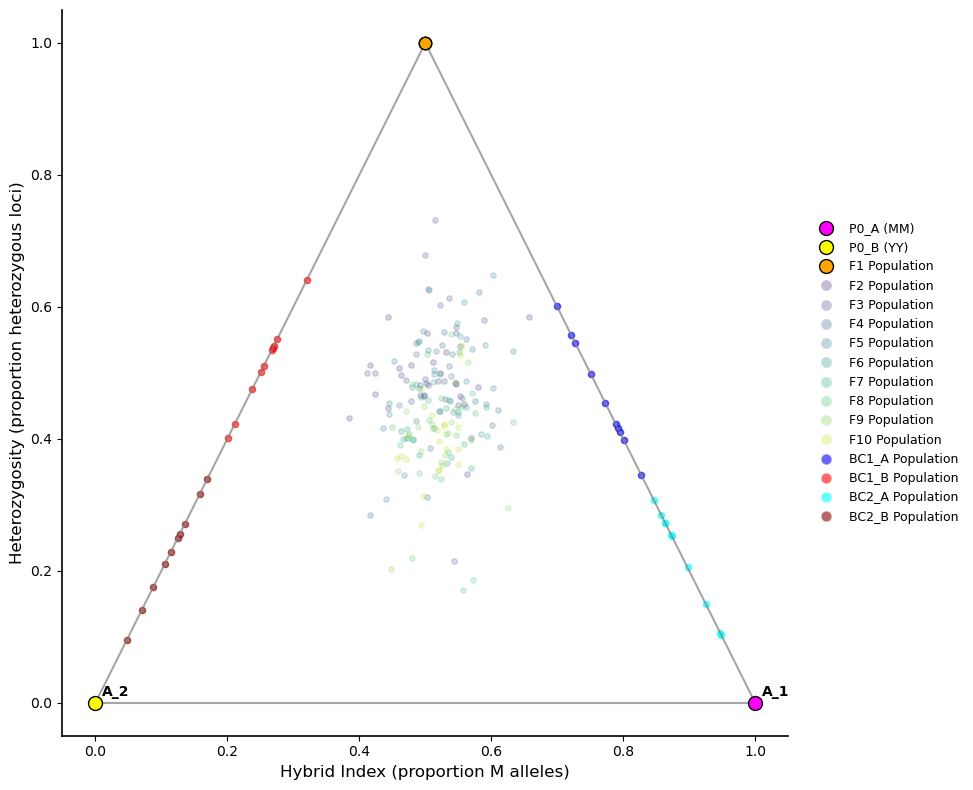

In [11]:
print("\n--- Plotting Triangle Plot ---")

# Create a new figure and a single subplot for the plot.
fig, ax = plt.subplots(figsize=(10, 8)) # Slightly larger for more generations

# Customise the plot's appearance
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

ax.set_xlabel("Hybrid Index (proportion M alleles)", fontsize=12)
ax.set_ylabel("Heterozygosity (proportion heterozygous loci)", fontsize=12)

# --- Plot the P0 and F1 reference points first (always the same) ---
# Use the first individual from the P0 populations for their HI/He
p0_a_hi = p0_a_population[0].calculate_hybrid_index()
p0_a_het = p0_a_population[0].calculate_heterozygosity()
p0_b_hi = p0_b_population[0].calculate_hybrid_index()
p0_b_het = p0_b_population[0].calculate_heterozygosity()

ax.scatter(p0_a_hi, p0_a_het, color='magenta', s=100, edgecolor='black', zorder=5, label='A_1 (MM)')
ax.scatter(p0_b_hi, p0_b_het, color='yellow', s=100, edgecolor='black', zorder=5, label='A_2 (YY)')

# For F1, use the calculated means, or plot individual F1 points if NUM_F1_INDIVIDUALS > 1
f1_df = df_recombination_summary[df_recombination_summary['Gen'] == 'F1']
ax.scatter(f1_df['Hi'], f1_df['He'], color='orange', s=80, edgecolor='black', zorder=4, label='F1')

# Add annotations (text labels) next to the P0 points for clear identification.
ax.annotate('A_1', (p0_a_hi, p0_a_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
ax.annotate('A_2', (p0_b_hi, p0_b_het), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

# It's better to annotate the 'average' F1 point or just let the scatter represent all F1s.
# If you want to annotate a single average F1 point:
# ax.annotate('F1', (np.mean(f1_df['Hi']), np.mean(f1_df['He'])), xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')


# --- Dynamically plot all F-generations from F2 up to target_f_generation ---
# Define a color palette for the F-generations
# Using Seaborn's palette for better color differentiation across multiple generations
f_gen_colors = sns.color_palette("viridis", target_f_generation - 1) # F2 to F_target_f_generation

for i in range(2, target_f_generation + 1):
    gen_label = f'F{i}'
    gen_df = df_recombination_summary[df_recombination_summary['Gen'] == gen_label]

    if not gen_df.empty: # Only plot if data exists for this generation
        ax.scatter(
            gen_df['Hi'],
            gen_df['He'],
            color=f_gen_colors[i-2], # Assign color from palette (f_gen_colors[0] is for F2)
            alpha=0.2,
            s=15,
            label=f'{gen_label} Population'
        )
    else:
        print(f"No data found for {gen_label} in df_recombination_summary.")


# --- Plot Backcross (BC) generations ---
# You can assign specific colors for BC lines or use another palette
bc_gen_colors = {
    'BC1_A': 'blue',
    'BC1_B': 'red',
    'BC2_A': 'cyan',
    'BC2_B': 'darkred'
    # Add more if you have BC3, etc.
}
bc_gen_order = ['BC1_A', 'BC1_B', 'BC2_A', 'BC2_B'] # Ensure consistent plotting order

for gen_label in bc_gen_order:
    gen_df = df_recombination_summary[df_recombination_summary['Gen'] == gen_label]
    if not gen_df.empty:
        ax.scatter(
            gen_df['Hi'],
            gen_df['He'],
            color=bc_gen_colors.get(gen_label, 'gray'), # Use assigned color, default to gray
            alpha=0.6,
            s=20,
            label=f'{gen_label} Population'
        )
    else:
        print(f"No data found for {gen_label} in df_recombination_summary.")


# Draw the edges of the triangular region.
triangle_edges = [
    [(0.0, 0.0), (0.5, 1.0)], # Edge from YY (0,0) to F1 (0.5,1)
    [(0.5, 1.0), (1.0, 0.0)], # Edge from F1 (0.5,1) to MM (1,0)
    [(0.0, 0.0), (1.0, 0.0)]  # Edge from YY (0,0) to MM (1,0) (the x-axis, representing pure homozygotes)
]
for (x0, y0), (x1, y1) in triangle_edges:
    ax.plot([x0, x1], [y0, y1], linestyle='-', color='gray', linewidth=1.5, alpha=0.7)

ax.set_xlim(-0.05, 1.05)
ax.set_ylim(-0.05, 1.05)
ax.grid(False)
ax.set_aspect('equal', adjustable='box') # Keep it a true triangle

# --- Create Custom Legend Elements Dynamically ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='magenta', markersize=10, markeredgecolor='black', label='P0_A (MM)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10, markeredgecolor='black', label='P0_B (YY)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10, markeredgecolor='black', label='F1 Population') # F1 can be multiple points
]

# Add F-generation legend elements
for i in range(2, target_f_generation + 1):
    gen_label = f'F{i}'
    if i-2 < len(f_gen_colors): # Ensure index is within bounds of color palette
        legend_elements.append(
            Line2D([0], [0], marker='o', color='w', markerfacecolor=f_gen_colors[i-2], alpha=0.3, markersize=8, label=f'{gen_label} Population')
        )

# Add BC-generation legend elements
for gen_label in bc_gen_order:
    legend_elements.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor=bc_gen_colors.get(gen_label, 'gray'), alpha=0.6, markersize=8, label=f'{gen_label} Population')
    )

ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False, fontsize=9)

plt.tight_layout()
plt.subplots_adjust(right=0.8) # Adjust subplot to make space for the legend
plt.savefig(f'triangle_plot_F{target_f_generation}_ChrLen{chromosome_length}.png', dpi=300, bbox_inches='tight')
plt.show()

### Chromosome Visualisation Function

In [12]:
# Chromosome Visualisation Function

def plot_individual_chromosomes(individuals_to_plot, titles, loci_per_chromosome, max_chromosomes_to_plot=1):
    """
    Visualises the alleles along a specified number of chromosomes for one or more individuals.
    Each diploid chromosome pair is shown with its two constituent chromatids.

    Args:
        individuals_to_plot (list): A list of Individual objects to visualise.
        titles (list): A list of titles for each individual, matching the order of individuals_to_plot.
        loci_per_chromosome (int): The length of each chromosome (number of loci).
        max_chromosomes_to_plot (int, optional): The maximum number of diploid chromosome pairs to plot per individual.
                                                  Defaults to 1 for a concise view across generations.
                                                  If set to None, plots all pairs (use with caution for F2+!).
    """
    if not individuals_to_plot:
        print("No individuals to plot.")
        return

    num_individuals = len(individuals_to_plot)
    
    # Determine the actual number of chromosome pairs we'll display for each individual.
    # We take the minimum of the individual's actual chromosome count and the 'max_chromosomes_to_plot' limit.
    actual_chroms_to_display_per_ind = max_chromosomes_to_plot if max_chromosomes_to_plot is not None else individuals_to_plot[0].num_chromosomes
    
    # Calculate the total number of subplots needed for the visualisations.
    # Each diploid pair consists of 2 chromatids, hence multiplying by 2.
    total_subplots = num_individuals * actual_chroms_to_display_per_ind * 2

    # Dynamically adjust figure size for better readability, especially with many loci or individuals.
    # The width scales with the number of subplots, and height scales with chromosome length.
    fig_width = total_subplots * 1.0
    fig_height = (loci_per_chromosome * 0.05) + 3

    # Ensure a minimum figure size for basic readability, regardless of input parameters.
    fig_width = max(10, fig_width)
    fig_height = max(6, fig_height)

    # Create the figure and a grid of subplots. `sharey=True` ensures all subplots share the same Y-axis limits.
    fig, axs = plt.subplots(1, total_subplots, figsize=(fig_width, fig_height), sharey=True)

    # If only one subplot is created (e.g., only one chromatid displayed), `axs` might not be an array.
    # Convert it to a list for consistent iteration.
    if total_subplots == 1:
        axs = [axs]

    # Drawing settings for individual allele blocks within the chromosome visualisation.
    block_width = 0.8    # Width of the rectangular block representing an allele.
    block_height = 0.9   # Height of the rectangular block.
    block_spacing = 1.1  # Vertical spacing between allele blocks.

    current_subplot_idx = 0 # Counter to keep track of the current subplot being drawn on.

    # Iterate through each individual selected for plotting.
    for ind_idx, individual in enumerate(individuals_to_plot):
        # Iterate through a limited number of diploid chromosome pairs for each individual.
        for pair_idx in range(min(len(individual.diploid_chromosome_pairs), actual_chroms_to_display_per_ind)):
            diploid_pair = individual.diploid_chromosome_pairs[pair_idx]

            # --- Plot Chromatid 1 (e.g., paternal origin) ---
            ax_chr1 = axs[current_subplot_idx]
            # Draw each allele as a coloured rectangle.
            for k, allele in enumerate(diploid_pair.chromatid1.alleles):
                y_pos = k * block_spacing
                ax_chr1.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr1.set_xlim(0, 1) # Set X-axis limits for the current subplot.
            ax_chr1.set_ylim(-block_spacing, loci_per_chromosome * block_spacing) # Set Y-axis limits.
            ax_chr1.axis('off') # Hide axis ticks and labels for a cleaner chromosome visualisation.
            # Add a label at the bottom of the chromatid indicating which chromosome pair and strand it is.
            ax_chr1.text(0.5, -0.05, f"Chr {pair_idx+1}a", ha='center', va='top', fontsize=9, transform=ax_chr1.transAxes)
            current_subplot_idx += 1 # Move to the next subplot.

            # --- Plot Chromatid 2 (e.g., maternal origin) ---
            ax_chr2 = axs[current_subplot_idx]
            # Draw each allele as a coloured rectangle.
            for k, allele in enumerate(diploid_pair.chromatid2.alleles):
                y_pos = k * block_spacing
                ax_chr2.add_patch(
                    mpatches.Rectangle((0.1, y_pos), block_width, block_height, color=col_map[allele])
                )
            ax_chr2.set_xlim(0, 1)
            ax_chr2.set_ylim(-block_spacing, loci_per_chromosome * block_spacing)
            ax_chr2.axis('off')
            ax_chr2.text(0.5, -0.05, f"Chr {pair_idx+1}b", ha='center', va='top', fontsize=9, transform=ax_chr2.transAxes)
            current_subplot_idx += 1

        # Add a common title for the entire individual (e.g., "P0_A Parent") above its set of chromosomes.
        # This calculates the mid-point x-coordinate across the subplots allocated for this individual.
        start_ax_idx_for_ind = ind_idx * (actual_chroms_to_display_per_ind * 2)
        end_ax_idx_for_ind = start_ax_idx_for_ind + (actual_chroms_to_display_per_ind * 2 - 1)
        
        mid_x = axs[start_ax_idx_for_ind].get_position().x0 + \
                (axs[end_ax_idx_for_ind].get_position().x1 - axs[start_ax_idx_for_ind].get_position().x0) / 2
        
        # Add the title text for the individual. A small offset (-0.02) is applied to subtly shift the title left.
        fig.text(mid_x - 0.02, 0.95, titles[ind_idx], ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Create a global legend for the allele colours (Magenta and Yellow).
    legend_patches = [
        mpatches.Patch(color=col_map[MAGENTA], label=f'{MAGENTA} (Magenta)'),
        mpatches.Patch(color=col_map[YELLOW], label=f'{YELLOW} (Yellow)')
    ]
    # Place the legend to the right of the plot area, vertically centred.
    fig.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(0.99, 0.5), frameon=False, fontsize=10)

    # Adjust subplot parameters for a tighter layout and proper spacing.
    plt.subplots_adjust(wspace=0.3)
    # Display the plot.
    plt.show()


--- Visualising Representative Chromosomes ---


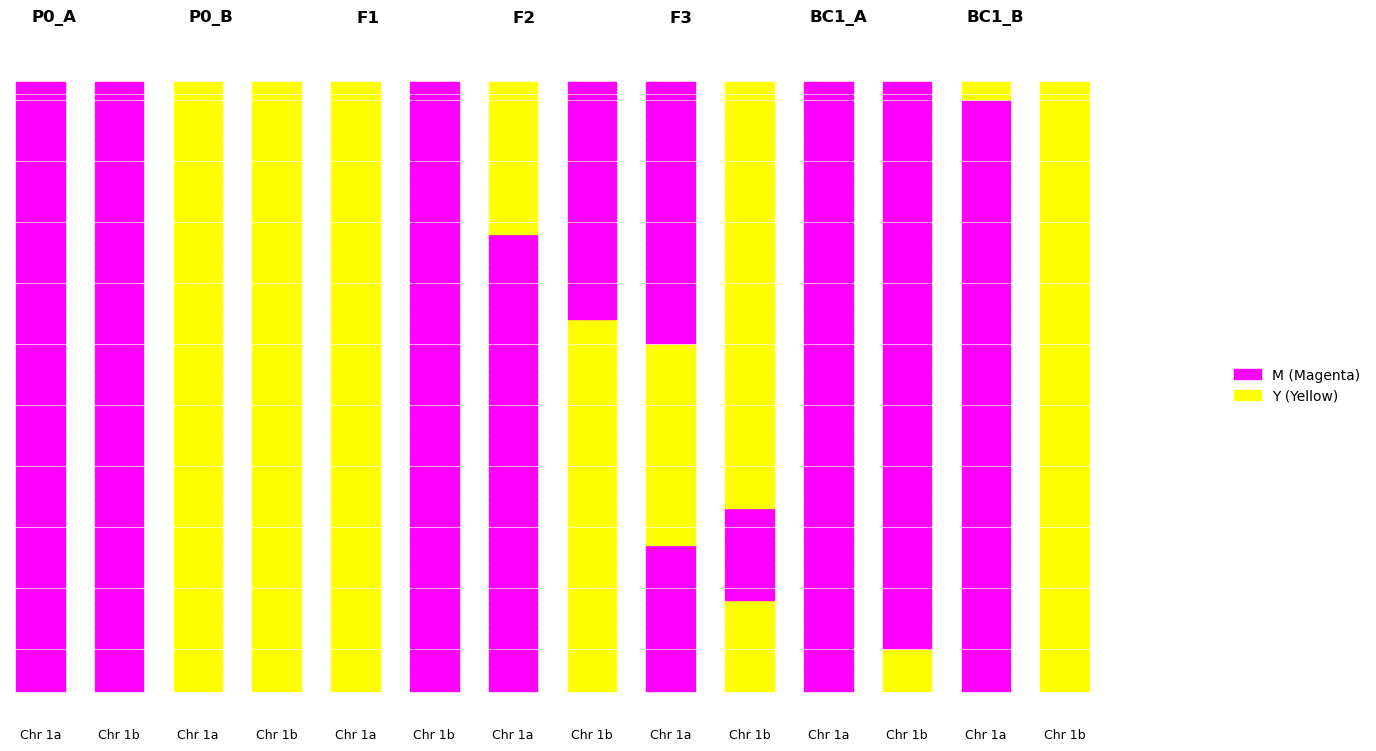

In [13]:
print("\n--- Visualising Representative Chromosomes ---")

# 1. Select representative individuals from the generated populations.
# P0_A: The initial Magenta homozygous parent.
representative_p0_a = p0_a_population[0] # Using [0] to be consistent with other population lists
# P0_B: The initial Yellow homozygous parent.
representative_p0_b = p0_b_population[0] # Using [0] to be consistent with other population lists

# F1: The first individual from the F1 generation.
representative_f1 = f1_population[0]

# F2: The first individual from the F2 generation.
# IMPORTANT: Access from the dictionary returned by simulate_f_generations
representative_f2 = all_f_populations['F2'][0]

# F3: The first individual from the F3 generation.
# IMPORTANT: Access from the dictionary returned by simulate_f_generations
representative_f3 = all_f_populations['F3'][0]

# BC1_A: The first individual from the F1 x P0_A backcross.
# Ensure bc1_a_population is generated before this block
representative_bc1_a = bc1_a_population[0]

# BC1_B: The first individual from the F1 x P0_B backcross.
# Ensure bc1_b_population is generated before this block
representative_bc1_b = bc1_b_population[0]


# 2. Compile lists of individuals and their corresponding titles for the plotting function.
individuals_to_plot = [
    representative_p0_a,
    representative_p0_b,
    representative_f1,
    representative_f2,
    representative_f3,
    representative_bc1_a,
    representative_bc1_b
]

titles = [
    "P0_A",
    "P0_B",
    "F1",
    "F2",
    "F3",
    "BC1_A",
    "BC1_B"
]

# Call the plotting function.
# We'll plot only the first chromosome pair for each individual for clarity across generations.
plot_individual_chromosomes(individuals_to_plot, titles, chromosome_length, max_chromosomes_to_plot=1)

In [ ]:
# Define the filename and path
filename = "test_chr_vis_plot.png" 

# Save the figure
plt.savefig(filename, dpi=300, bbox_inches='tight')

# Display the plot (optional, if you only want to save without displaying)
plt.show()

print(f"Plot saved as {filename}")

### Save Dataframes

In [ ]:
# Create output folder if it doesn't exist
output_folder = 'output_data'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Created folder: {output_folder}")
else:
    print(f"Folder already exists: {output_folder}")

# Save each DataFrame to individual CSV files in the output folder
print("\n Saving DataFrames to CSV files")

# Save DataFrame 1: Locus-level genetic data
df_genetic_data.to_csv(f'{output_folder}/genetic_data_locus_level.csv', index=False)
print("Saved: genetic_data_locus_level.csv")

# Save DataFrame 2: Individual-level recombination summary
df_recombination_summary.to_csv(f'{output_folder}/individual_block_summary.csv', index=False)
print("Saved: individual_block_summary.csv")

# Save DataFrame 3: Simplified block data
df_simplified_blocks.to_csv(f'{output_folder}/detailed_block_data.csv', index=False)
print("Saved: detailed_block_data.csv")

print(f"\nAll CSV files have been saved to the '{output_folder}' folder")

### Filter data for indiviudal summary level

In [ ]:
# --- Filtering the DataFrame for separate plots ---

# F-generations
df_f_gens = df_recombination_summary[df_recombination_summary['Gen'].str.startswith('F') |
                                     df_recombination_summary['Gen'].isin(['P0_A', 'P0_B'])].copy()
f_gen_order = ['P0_A', 'P0_B', 'F1'] + [f'F{i}' for i in range(2, 9)]
df_f_gens['Gen'] = pd.Categorical(df_f_gens['Gen'], categories=f_gen_order, ordered=True)
df_f_gens = df_f_gens.sort_values('Gen').dropna(subset=['Gen'])


# BC-generations
df_bc_gens = df_recombination_summary[df_recombination_summary['Gen'].str.startswith('BC')].copy()
# --- UPDATED bc_gen_order to match your data ---
bc_gen_order = ['BC1_A', 'BC1_B', 'BC2_A', 'BC2_B'] # Include all specific BC labels you have!
# If you have BC3_A, BC3_B etc., add them here:
# bc_gen_order = ['BC1_A', 'BC1_B', 'BC2_A', 'BC2_B', 'BC3_A', 'BC3_B']
# --- END UPDATED bc_gen_order ---
df_bc_gens['Gen'] = pd.Categorical(df_bc_gens['Gen'], categories=bc_gen_order, ordered=True)
df_bc_gens = df_bc_gens.sort_values('Gen').dropna(subset=['Gen'])


print("\nDataFrame for F-generations head:")
print(df_f_gens.head())
print("\nDataFrame for BC-generations head:")
print(df_bc_gens.head()) # This should now show data!


### Data Visualisation indiviudal summary level

In [ ]:
# --- Plotting F-generations ---
plt.figure(figsize=(12, 7))

sns.violinplot(
    data=df_f_gens,
    x='Gen',
    y='Scaled_Mean_Avg_Block_Length',
    inner='quartile',
    color='lightgray',
    cut=0,
    linewidth=1
)

sns.pointplot(
    data=df_f_gens,
    x='Gen',
    y='Scaled_Mean_Avg_Block_Length',
    estimator='mean',
    color='red',
    marker='D',
    linestyles='--',
    capsize=0.1,
    err_kws={'linewidth': 1.5}
)

plt.title(f'F-Generations: Scaled Mean Average Block Lengths by Generation\n(Chromosome Length = {chromosome_length} Loci)')
plt.xlabel('Generation')
plt.ylabel('Scaled Mean Average Block Length (Chromosome Length = 1.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0, top=1.0)
plt.tight_layout()
plt.show()

# --- Plotting BC-generations ---
plt.figure(figsize=(8, 7))

sns.violinplot(
    data=df_bc_gens, # IMPORTANT: Using df_bc_gens here
    x='Gen',
    y='Scaled_Mean_Avg_Block_Length',
    inner='quartile',
    color='lightblue',
    cut=0,
    linewidth=1
)

sns.pointplot(
    data=df_bc_gens, # IMPORTANT: Using df_bc_gens here
    x='Gen',
    y='Scaled_Mean_Avg_Block_Length',
    estimator='mean',
    color='darkblue',
    marker='o',
    linestyles='--',
    capsize=0.1,
    err_kws={'linewidth': 1.5}
)

plt.title(f'BC-Generations: Scaled Mean Average Block Lengths by Generation\n(Chromosome Length = {chromosome_length} Loci)')
plt.xlabel('Generation')
plt.ylabel('Scaled Mean Average Block Length (Chromosome Length = 1.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0, top=1.0)
plt.tight_layout()
plt.show()

### Filtering for all block plots

In [ ]:
# --- Filter df_simplified_blocks for F-generations ---
df_simplified_blocks_f_gens = df_simplified_blocks[
    df_simplified_blocks['Generation'].str.startswith('F') |
    df_simplified_blocks['Generation'].isin(['P0_A', 'P0_B'])
].copy() # .copy() prevents SettingWithCopyWarning

# Set categorical order for F-generations
df_simplified_blocks_f_gens['Generation'] = pd.Categorical(
    df_simplified_blocks_f_gens['Generation'],
    categories=f_gen_order,
    ordered=True
)
df_simplified_blocks_f_gens = df_simplified_blocks_f_gens.sort_values('Generation').dropna(subset=['Generation'])

print("\nHead of df_simplified_blocks_f_gens:")
print(df_simplified_blocks_f_gens.head())


# --- Filter df_simplified_blocks for BC-generations ---
df_simplified_blocks_bc_gens = df_simplified_blocks[
    df_simplified_blocks['Generation'].str.startswith('BC')
].copy() # .copy() prevents SettingWithCopyWarning

# Set categorical order for BC-generations
df_simplified_blocks_bc_gens['Generation'] = pd.Categorical(
    df_simplified_blocks_bc_gens['Generation'],
    categories=bc_gen_order,
    ordered=True
)
df_simplified_blocks_bc_gens = df_simplified_blocks_bc_gens.sort_values('Generation').dropna(subset=['Generation'])

print("\nHead of df_simplified_blocks_bc_gens:")
print(df_simplified_blocks_bc_gens.head())

In [ ]:
# --- Plotting Individual Block Lengths (F-Generations) ---
plt.figure(figsize=(12, 8)) # Wider figure for F-gens

sns.violinplot(
    data=df_simplified_blocks_f_gens, # Using the filtered F-gens DataFrame
    x='Generation',
    y='Block_Length',
    inner='quartile', # Show quartiles within violins
    color='lightgreen', # A fresh color
    cut=0, # Trim violin plots at the min/max of the data
    linewidth=1
)
# REMOVED: sns.pointplot for raw individual block lengths

plt.title(f'F-Generations: Distribution of Individual Block Lengths by Generation\n(Chromosome Length = {chromosome_length} Loci)')
plt.xlabel('Generation')
plt.ylabel('Block Length (Loci)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0, top=chromosome_length)
plt.tight_layout()
plt.show()

# --- Plotting Individual Block Lengths (BC-Generations) ---
plt.figure(figsize=(8, 8)) # Adjust figure size for BC-gens

sns.violinplot(
    data=df_simplified_blocks_bc_gens, # Using the filtered BC-gens DataFrame
    x='Generation',
    y='Block_Length',
    inner='quartile',
    color='gold', # Another distinct color
    cut=0,
    linewidth=1
)
# REMOVED: sns.pointplot for raw individual block lengths

plt.title(f'BC-Generations: Distribution of Individual Block Lengths by Generation\n(Chromosome Length = {chromosome_length} Loci)')
plt.xlabel('Generation')
plt.ylabel('Block Length (Loci)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(bottom=0, top=chromosome_length)
plt.tight_layout()
plt.show()